#### Regression Analysis on Emergency Responding Time and ML Prediction

In this notebook, we did regression analysis on cardiac arrest interventions using statsmodels package and did machine learning prediction (train, parameter tuning, prediction) on the corresponding emergency operation time by gradient boosting model and kernel SVM using sklearn package. The main findings of this analysis are, by controling other variables, if the intervention is covered by medical facilities (`medical_coverage = 1`), the operation time (`total_time` in dataset) will decrease significantly (with p-value = 0.000). The prediction performance of ML models does not show much differences (Loss_GBR = 746.94, Loss_SVM = 770.16).  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
itv_aed = pd.read_csv(
    '/Users/lye/Downloads/MDA/Github-MDA2024/1_Data/CLEANED/intervention_aed_related_distance.csv',
    low_memory=False)

itv_aed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43093 entries, 0 to 43092
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   mission_id                        43093 non-null  int64  
 1   service_name                      38978 non-null  object 
 2   postalcode_permanence             27284 non-null  float64
 3   cityname_permanence               28483 non-null  object 
 4   streetname_permanence             28631 non-null  object 
 5   housenumber_permanence            2156 non-null   float64
 6   latitude_permanence               39916 non-null  float64
 7   longitude_permanence              40255 non-null  float64
 8   permanence_short_name             43053 non-null  object 
 9   permanence_long_name              38982 non-null  object 
 10  vector_type                       42545 non-null  object 
 11  eventtype_firstcall               27434 non-null  object 
 12  even

In [3]:
## Datetime validation

itv_aed['t0'] = pd.to_datetime(itv_aed['t0'])
itv_aed['t3'] = pd.to_datetime(itv_aed['t3'])
itv_aed['t5'] = pd.to_datetime(itv_aed['t5'])
itv_aed['t6'] = pd.to_datetime(itv_aed['t6'])
itv_aed['t7'] = pd.to_datetime(itv_aed['t7'])
itv_aed['t3-t0'] = (itv_aed['t3'] - itv_aed['t0']).dt.total_seconds() / 60
itv_aed['t5-t0'] = (itv_aed['t5'] - itv_aed['t0']).dt.total_seconds() / 60
itv_aed['t6-t0'] = (itv_aed['t6'] - itv_aed['t0']).dt.total_seconds() / 60
itv_aed['total_time'] = (itv_aed['t7'] - itv_aed['t0']).dt.total_seconds() / 60

itv_aed.loc[(itv_aed['t3-t0'] <= 0) | (itv_aed['t3-t0'] > 6 * 60),
            't3-t0'] = np.nan
itv_aed.loc[(itv_aed['waiting_time'] <= 0) |
            (itv_aed['waiting_time'] > 6 * 60), 'waiting_time'] = np.nan
itv_aed['t3-t0'] = itv_aed.apply(
    lambda x: x['waiting_time']
    if pd.isna(x['t3-t0']) and pd.notna(x['waiting_time']) else x['t3-t0'],
    axis=1)

itv_aed.loc[(itv_aed['t5-t0'] <= 0) | (itv_aed['t5-t0'] > 12 * 60) |
            (itv_aed['t5-t0'] <= itv_aed['t3-t0']), 't5-t0'] = np.nan

itv_aed.loc[(itv_aed['total_time'] <= 0) |
            (itv_aed['total_time'] <= itv_aed['t5-t0']), 'total_time'] = np.nan

itv_aed.loc[(itv_aed['t6-t0'] <= 0) |
            (itv_aed['t6-t0'] <= itv_aed['t5-t0']) |
            (itv_aed['t6-t0'] >= itv_aed['total_time']), 't6-t0'] = np.nan

itv_aed.drop(columns=['waiting_time'], inplace=True)
itv_aed.rename(columns={
    't3-t0': 'waiting_time',
    't5-t0': 'time_to_hospital',
    't6-t0': 'operation_time'
}, inplace=True)  ## rename to waiting_time & time_to_hospital $ operation_time

itv_aed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43093 entries, 0 to 43092
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   mission_id                        43093 non-null  int64         
 1   service_name                      38978 non-null  object        
 2   postalcode_permanence             27284 non-null  float64       
 3   cityname_permanence               28483 non-null  object        
 4   streetname_permanence             28631 non-null  object        
 5   housenumber_permanence            2156 non-null   float64       
 6   latitude_permanence               39916 non-null  float64       
 7   longitude_permanence              40255 non-null  float64       
 8   permanence_short_name             43053 non-null  object        
 9   permanence_long_name              38982 non-null  object        
 10  vector_type                       42545 non-nu

In [4]:
## drop duplicates and missing values

itv_aed.dropna(subset=[
    'total_time', 'aed_distance', 'hospital_distance',
    'province', 'vector_type', 't0_DayName', 't0_Month', 't0_Hour'
], inplace=True)

itv_aed.drop_duplicates(subset=['mission_id'], inplace=True)

## validate vector_type to "MUG", "AMBULANCE", "PIT"
itv_aed['vector_type'] = itv_aed['vector_type'].apply(lambda x: "AMBULANCE" if any(
    i in x.lower() for i in ["ambulance", "amb"]) else 'MUG' if any(
    i in x.lower() for i in ['mug']) else 'PIT' if any(
    i in x.lower() for i in ['pit']) else x)

itv_aed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 0 to 30942
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   mission_id                        16860 non-null  int64         
 1   service_name                      16859 non-null  object        
 2   postalcode_permanence             16351 non-null  float64       
 3   cityname_permanence               16804 non-null  object        
 4   streetname_permanence             16858 non-null  object        
 5   housenumber_permanence            1037 non-null   float64       
 6   latitude_permanence               16838 non-null  float64       
 7   longitude_permanence              16783 non-null  float64       
 8   permanence_short_name             16860 non-null  object        
 9   permanence_long_name              16860 non-null  object        
 10  vector_type                       16860 non-null  o

In [5]:
## Delete 'provincie' in province column
itv_aed['province'] = itv_aed['province'].apply(lambda x: x.replace('Provincie ', ''))
itv_aed['province'].value_counts()

province
Antwerpen                         4319
Henegouwen                        2921
Brussels Hoofdstedelijk Gewest    2744
Luik                              2248
Limburg                           1869
Namen                             1149
Waals-Brabant                      780
Luxemburg                          674
Vlaams-Brabant                     151
West-Vlaanderen                      3
Oost-Vlaanderen                      2
Name: count, dtype: int64

In [6]:
## Generate variable "medical coverage" binary variable: 1 if the intervention is covered by aed/hospital else 0

itv_aed['medical_coverage'] = itv_aed.apply(lambda x: 1 if x['aed_distance'] <= 200 or x['hospital_distance'] <= 2000 else 0, axis=1)
itv_aed['medical_coverage'].value_counts()

medical_coverage
0    8851
1    8009
Name: count, dtype: int64

In [7]:
itv_aed['t0_Hour'].value_counts()

t0_Hour
10.0    1171
11.0    1142
9.0     1094
12.0    1076
13.0    1014
14.0    1001
15.0     946
8.0      891
17.0     836
18.0     835
16.0     805
19.0     781
20.0     695
21.0     641
7.0      595
22.0     570
23.0     530
0.0      396
6.0      392
1.0      322
4.0      299
2.0      299
3.0      267
5.0      262
Name: count, dtype: int64

In [8]:
itv_aed['t0_Time'] = itv_aed['t0_Hour'].apply(
    lambda x: 'Morning' if x in [6., 7., 8., 9., 10., 11.] else 'Afternoon'
    if x in [12., 13., 14., 15., 16., 17.] else 'Evening'
    if x in [18., 19., 20., 21., 22., 23.] else 'Night'
)  ## create time of day variable to Morning, Afternoon, Evening, Night

In [9]:
itv_aed.to_csv('/Users/lye/Downloads/MDA/Github-MDA2024/1_Data/CLEANED/clean_itv_aed_for_reg_analysis.csv', index=False)

In [10]:
columns_to_keep = [
    'aed_distance', 'hospital_distance', 'medical_coverage', 'total_time',
    'province', 'vector_type', 'eventlevel_trip', 'eventtype_trip' ,'t0_DayName', 't0_Month',
    't0_Time', 't0_Hour'
]

itv_ca = itv_aed.loc[itv_aed['eventtype_trip']=='P003 - Cardiac arrest'].copy() ## use only cardiac arrest data for regression analysis
itv_reg = itv_ca[columns_to_keep].copy()
itv_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3643 entries, 4 to 30942
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   aed_distance       3643 non-null   float64
 1   hospital_distance  3643 non-null   float64
 2   medical_coverage   3643 non-null   int64  
 3   total_time         3643 non-null   float64
 4   province           3643 non-null   object 
 5   vector_type        3643 non-null   object 
 6   eventlevel_trip    3642 non-null   object 
 7   eventtype_trip     3643 non-null   object 
 8   t0_DayName         3643 non-null   object 
 9   t0_Month           3643 non-null   float64
 10  t0_Time            3643 non-null   object 
 11  t0_Hour            3643 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 370.0+ KB


In [11]:
## one-hot encoding for regression analysis

itv_reg = pd.get_dummies(itv_reg,
                         columns=[
                             'province', 'vector_type',
                             'eventlevel_trip', 't0_DayName', 't0_Month',
                             't0_Time'
                         ],
                         drop_first=True)
itv_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3643 entries, 4 to 30942
Data columns (total 42 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   aed_distance                             3643 non-null   float64
 1   hospital_distance                        3643 non-null   float64
 2   medical_coverage                         3643 non-null   int64  
 3   total_time                               3643 non-null   float64
 4   eventtype_trip                           3643 non-null   object 
 5   t0_Hour                                  3643 non-null   float64
 6   province_Brussels Hoofdstedelijk Gewest  3643 non-null   bool   
 7   province_Henegouwen                      3643 non-null   bool   
 8   province_Limburg                         3643 non-null   bool   
 9   province_Luik                            3643 non-null   bool   
 10  province_Luxemburg                       3643 non-nu

In [12]:
itv_reg.columns

Index(['aed_distance', 'hospital_distance', 'medical_coverage', 'total_time',
       'eventtype_trip', 't0_Hour', 'province_Brussels Hoofdstedelijk Gewest',
       'province_Henegouwen', 'province_Limburg', 'province_Luik',
       'province_Luxemburg', 'province_Namen', 'province_Vlaams-Brabant',
       'province_Waals-Brabant', 'province_West-Vlaanderen', 'vector_type_MUG',
       'vector_type_PIT', 'eventlevel_trip_N1', 'eventlevel_trip_N2',
       'eventlevel_trip_N5', 'eventlevel_trip_N6', 'eventlevel_trip_N7B',
       't0_DayName_Monday', 't0_DayName_Saturday', 't0_DayName_Sunday',
       't0_DayName_Thursday', 't0_DayName_Tuesday', 't0_DayName_Wednesday',
       't0_Month_2.0', 't0_Month_3.0', 't0_Month_4.0', 't0_Month_5.0',
       't0_Month_6.0', 't0_Month_7.0', 't0_Month_8.0', 't0_Month_9.0',
       't0_Month_10.0', 't0_Month_11.0', 't0_Month_12.0', 't0_Time_Evening',
       't0_Time_Morning', 't0_Time_Night'],
      dtype='object')

In [13]:
## OLS regression on total_time
import statsmodels.api as sm

X_var = [
        'medical_coverage', 'hospital_distance',
        'province_Brussels Hoofdstedelijk Gewest', 'province_Henegouwen',
        'province_Limburg', 'province_Luik', 'province_Luxemburg',
        'province_Namen', 'province_Vlaams-Brabant', 'province_Waals-Brabant',
        'province_West-Vlaanderen',
        'vector_type_MUG', 'vector_type_PIT',
        'eventlevel_trip_N1', 'eventlevel_trip_N2', 'eventlevel_trip_N5', 'eventlevel_trip_N6',
        'eventlevel_trip_N7B',
        't0_DayName_Monday', 't0_DayName_Saturday', 't0_DayName_Sunday',
        't0_DayName_Thursday', 't0_DayName_Tuesday', 't0_DayName_Wednesday',
        't0_Month_2.0', 't0_Month_3.0', 't0_Month_4.0',
        't0_Month_5.0', 't0_Month_6.0', 't0_Month_7.0', 't0_Month_8.0',
        't0_Month_9.0', 't0_Month_10.0', 't0_Month_11.0', 't0_Month_12.0',
        't0_Time_Evening', 't0_Time_Morning', 't0_Time_Night'
]

y_var = 'total_time'

X = itv_reg[X_var]
y = itv_reg[y_var]
X = sm.add_constant(X)

model = sm.OLS(y, X.astype(float)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             total_time   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.639
Date:                Sun, 26 May 2024   Prob (F-statistic):           3.17e-52
Time:                        02:10:40   Log-Likelihood:                -17566.
No. Observations:                3643   AIC:                         3.521e+04
Df Residuals:                    3604   BIC:                         3.545e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      54.5235      2.589     21.059      0.000      49.447      59.600
medical_coverage                           -4.8251      1.169     -4.129      0.000      -7.116      -2.534
hospital_distance                           0.0013      0.000     10.064      0.000       0.001       0.002
province_Brussels Hoofdstedelijk Gewest    -3.6636      2.225     -1.646      0.100      -8.027       0.699
province_Henegouwen                         0.3977      1.649      0.241      0.809      -2.836       3.631
province_Limburg                            2.7565      1.799      1.532      0.126      -0.771       6.284
province_Luik                               5.4663      1.645      3.322      0.001       2.240       8.692
province_Luxemburg                          1.7375      2.699      0.644      0.520      -3.555       7.030
province_Namen                             -0.5844      2.417     -0.242      0.809      -5.324       4.155
province_Vlaams-Brabant                   -20.6131      8.188     -2.517      0.012     -36.667      -4.559
province_Waals-Brabant                      4.1509      3.057      1.358      0.175      -1.842      10.144
province_West-Vlaanderen                    1.3778     30.319      0.045      0.964     -58.066      60.821
vector_type_MUG                             4.0132      1.165      3.445      0.001       1.729       6.297
vector_type_PIT                             5.9583      3.061      1.946      0.052      -0.043      11.960
eventlevel_trip_N1                         -0.6523      1.434     -0.455      0.649      -3.464       2.160
eventlevel_trip_N2                         -2.5995      2.349     -1.107      0.269      -7.205       2.006
eventlevel_trip_N5                         -9.5371      2.156     -4.423      0.000     -13.765      -5.309
eventlevel_trip_N6                        -24.0683     10.183     -2.364      0.018     -44.033      -4.103
eventlevel_trip_N7B                        -8.5711     21.484     -0.399      0.690     -50.693      33.551
t0_DayName_Monday                          -4.1648      1.936     -2.152      0.031      -7.960      -0.370
t0_DayName_Saturday                        -4.6228      1.889     -2.448      0.014      -8.326      -0.920
t0_DayName_Sunday                          -4.6990      1.872     -2.510      0.012      -8.369      -1.029
t0_DayName_Thursday                        -3.4123      1.935     -1.763      0.078      -7.207       0.382
t0_DayName_Tuesday                         -3.5435      1.952     -1.815      0.070      -7.371       0.284
t0_DayName_Wednesday                       -2.6699      1.935     -1.380      0.168      -6.464       1.125
t0_Month_2.0                                4.4735      2.2

In [56]:
## GradientBoost prediction on total_time

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut

## prepare output and input variables
itv_model = itv_ca[columns_to_keep].copy()
y = itv_model['total_time']
X = itv_model.drop(columns=['total_time', 'medical_coverage', 'eventtype_trip'], inplace=False)

## one-hot encoding and standard scaling for input variables
ct = ColumnTransformer([
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'),
     ['province', 'vector_type', 'eventlevel_trip', 't0_DayName', 't0_Month', 't0_Hour', 't0_Time']),
    ('standardize', StandardScaler(), ['aed_distance', 'hospital_distance'])
])

## GradientBoosting pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16) ## 80% train, 20% test

gbr_pipe = Pipeline([
    ('transform', ct),
    #('reduce_dim', PCA(n_components=5, svd_solver="arpack")), ## 'arpack' for sparse input matrix
    ('gbr', GradientBoostingRegressor(n_estimators=100,
                                      learning_rate=0.01,
                                      subsample=1,
                                      loss='squared_error',
                                      max_depth=3,
                                      random_state=42))
])

gbr = gbr_pipe.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

print('The MSE of GradientBoosting is:', mse(y_test, y_pred))

The MSE of GradientBoosting is: 746.9421872245049


In [49]:
## Tuning hyperparameters with GridSearchCV

import warnings
with warnings.catch_warnings(): ## suppress user warnings: "The least populated class in y has only 1 members, which is less than n_splits=5.",
    ## which can cause the user warning in grid search phase
    warnings.simplefilter("ignore")

    param_grid_gbr = {
        # 'reduce_dim__n_components': [i+1 for i in range(3, 13)],  ## PCA components if using PCA to reduce dimension
        'gbr__n_estimators': [50, 100, 200, 500],
        'gbr__learning_rate': [0.005, 0.01, 0.1, 1],
        'gbr__subsample': [0.5, 0.75, 1.0],
        'gbr__max_depth': range(3, 13, 2),
        'gbr__loss': ['squared_error', 'huber']
    }

    loocv = LeaveOneOut() ## Use leave-one-out cross-validation for grid search to avoid sparse data splitting issue
    gridsearch = GridSearchCV(gbr_pipe,
                              param_grid_gbr,
                              scoring='neg_mean_squared_error',
                              cv=5, # loocv, ## Use leave-one-out cross-validation for grid search may take pretty long time
                              # n_jobs=-1, ## Use all processors for parallel computing if possible
                              verbose=0).fit(X_train, y_train)
    print('The best parameters are:', gridsearch.best_params_, 'with negative MSE:', gridsearch.best_score_)

    ## test the model with best parameters in test set
    loss = gridsearch.score(X_test, y_test)
    print('The negative MSE of GradientBoost(test set) with best parameters is:', loss)

The best parameters are: {'gbr__learning_rate': 0.01, 'gbr__loss': 'huber', 'gbr__max_depth': 3, 'gbr__n_estimators': 500, 'gbr__subsample': 0.5} with negative MSE: -951.6590411295044
The negative MSE of GradientBoost(test set) with best parameters is: -747.3903878942782


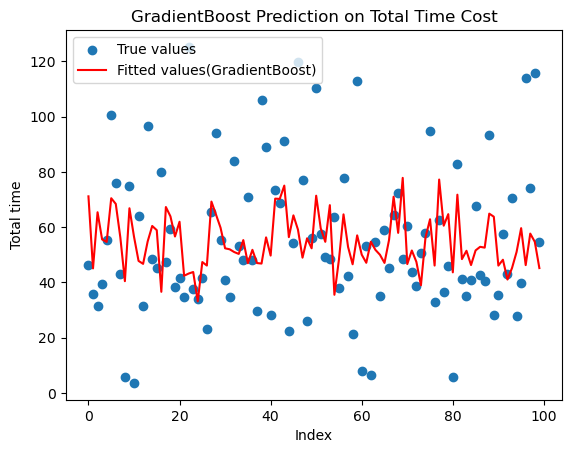

In [52]:
## visualize the regression results on test set

def visualize_results(X_test, y_test, model_name: str, gridsearch, num_samples=100):
    plt.figure()
    preds = gridsearch.predict(X_test)
    random_indices = np.random.choice(range(len(y_test)), num_samples, replace=False)
    plt.scatter(np.arange(num_samples), y_test.values[random_indices], label='True values')
    plt.plot(np.arange(num_samples), preds[random_indices], color='red', label=f'Fitted values({model_name})')
    plt.xlabel('Index')
    plt.ylabel('Total time')
    plt.title(f'{model_name} Prediction on Total Time Cost')
    plt.legend()
    plt.show()


## GradientBoost regression prediction vs. true value in test set
np.random.seed(42)
visualize_results(X_test, y_test, 'GradientBoost', gridsearch, num_samples=100)


In [51]:
## SVM prediction on total_time

svm_pipe = Pipeline([
    ('transform', ct),
    # ('reduce_dim', PCA(n_components=5, svd_solver="arpack")), ## 'arpack' for sparse input matrix
    ('svm', SVR(kernel='rbf', C=1, epsilon=0.1)) ## rbf kernel, C: penalty parameter(the higher the less regularization) , epsilon: margin of tolerance
])

svm_reg = svm_pipe.fit(X_train, y_train)
y_pred = svm_pipe.predict(X_test)

print('The MSE of SVM regression is:', mse(y_test, y_pred))

The MSE of SVM regression is: 767.6981080872646


In [53]:
## Tuning hyperparameters for SVM regression with GridSearchCV

import warnings
with warnings.catch_warnings():  ## suppress user warnings: "The least populated class in y has only 1 members, which is less than n_splits=5.",
                                ## which can cause the user warning in grid search phase
    warnings.simplefilter("ignore")

    param_grid_svm = {
        # 'reduce_dim__n_components': [i+1 for i in range(3, 13)],  ## PCA components
        'svm__kernel': ['poly', 'rbf', 'sigmoid'],
        'svm__C': [0.01, 0.1, 1, 10, 100, 200],
        'svm__epsilon': [0.01, 0.1, 1, 10, 50, 100],
        'svm__gamma': ['scale', 'auto']
    }

    gridsearch = GridSearchCV(
        svm_pipe,
        param_grid_svm,
        scoring='neg_mean_squared_error',
        cv=5,  # loocv, ## Use leave-one-out cross-validation for grid search may take pretty long time
        # n_jobs=-1, ## Use all processors for parallel computing if possible
        verbose=0).fit(X_train, y_train)
    print('The best parameters are:', gridsearch.best_params_,
          'with negative MSE:', gridsearch.best_score_)

    ## test the model with best parameters in test set
    loss = gridsearch.score(X_test, y_test)
    print('The negative MSE of SVM(test set) with best parameters is:', loss)

The best parameters are: {'svm__C': 100, 'svm__epsilon': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'} with negative MSE: -972.6371071397673
The negative MSE of SVM(test set) with best parameters is: -770.1613223992158


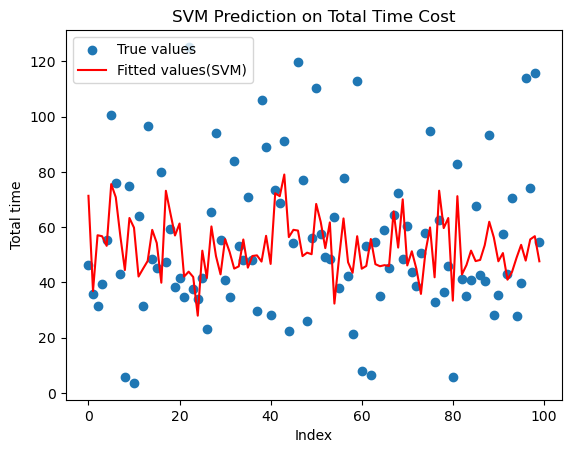

In [54]:
## SVM regression prediction vs. true value in test set
np.random.seed(42)
visualize_results(X_test, y_test, 'SVM', gridsearch, num_samples=100)